In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.PredictorProvider import LinearPredictorProvider
from src.CorrectorProvider import LinearCorrectorProvider
import random

# %matplotlib widget
from matplotlib import rc
rc('animation', html='html5')


In [2]:
k = 1
m = 1

omega = np.sqrt(k / m)


DELTA_T = 1e-2
times = np.arange(0, 20, DELTA_T)

amp = 1.0
true_states = np.vstack([amp * np.cos(times * omega), -amp * omega * np.sin(times * omega), -amp * omega**2 * np.cos(times * omega)])


In [3]:

class LinearStatePredictor(LinearPredictorProvider):
    def linear_prop_mat(self, state, dt):
        return np.array([[1, dt, dt**2 / 2],
                         [0, 1, dt],
                         # [-k/m, 0, 0]])
                         [0, 0, 1]])  

class LinearPosCorrector(LinearCorrectorProvider):
    def linear_obs_mat(self):
        return np.array([[1, 0, 0]])

class LinearAccelCorrector(LinearCorrectorProvider):
    def linear_obs_mat(self):
        return np.array([[0, 0, 1]])

# process_noise = 1e-5 * np.eye(3)


process_noise = np.array([[1e-5, 0, 0]
                         ,[0, 1e-5, 0]
                         ,[0, 0, 5e-2]])

measurement_noise = 1e-2
a_measurement_noise = 1e-2

state_predictor = LinearStatePredictor(process_noise, 0.0)
pos_corrector = LinearPosCorrector(measurement_noise, 0.0)
accel_corrector = LinearAccelCorrector(a_measurement_noise, 0.0)

starting_state = np.array([0.0, 0.0, 0.0])


pos_measurements = pos_corrector.linear_obs_mat() @ true_states + np.sqrt(measurement_noise) * np.random.randn(len(times))
accel_measurements = accel_corrector.linear_obs_mat() @ true_states + np.sqrt(a_measurement_noise) * np.random.randn(len(times))



## True Data Stuff

In [4]:
true_states_cov = np.cov(true_states)
print(true_states_cov)


[[ 0.50767864 -0.01940772 -0.50767864]
 [-0.01940772  0.48986051  0.01940772]
 [-0.50767864  0.01940772  0.50767864]]


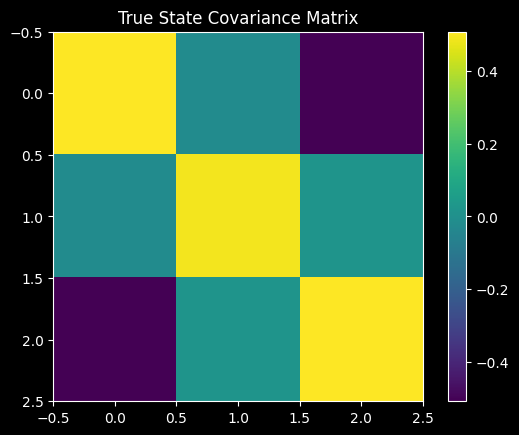

In [5]:
plt.imshow(true_states_cov, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('True State Covariance Matrix')
plt.show()


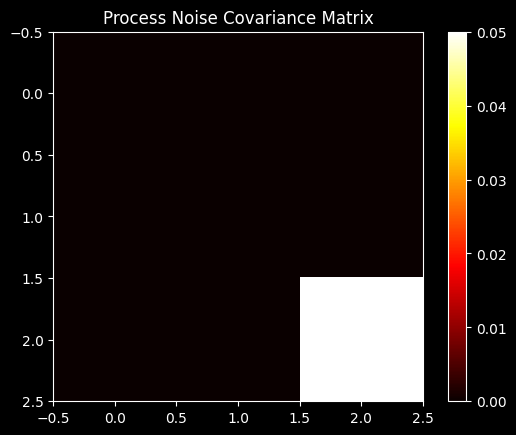

In [6]:
plt.imshow(process_noise, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Process Noise Covariance Matrix')
plt.show()


In [7]:
pos_measurements.shape


(1, 2000)

## Running the filter

In [8]:

state_history = np.zeros((3, len(times)))
cov_history = np.zeros((3, 3, len(times)))

state = starting_state
cov = true_states_cov

for ind, t in enumerate(times):
    state, cov = state_predictor.predict(state, cov, DELTA_T)

    if random.randint(0, 1):
        state, cov = pos_corrector.correct(state, cov, pos_measurements[:, ind], state_predictor)

    if random.randint(0, 1):
        state, cov = accel_corrector.correct(state, cov, accel_measurements[:, ind], state_predictor)

    state_history[:, ind] = state
    cov_history[:, :, ind] = cov



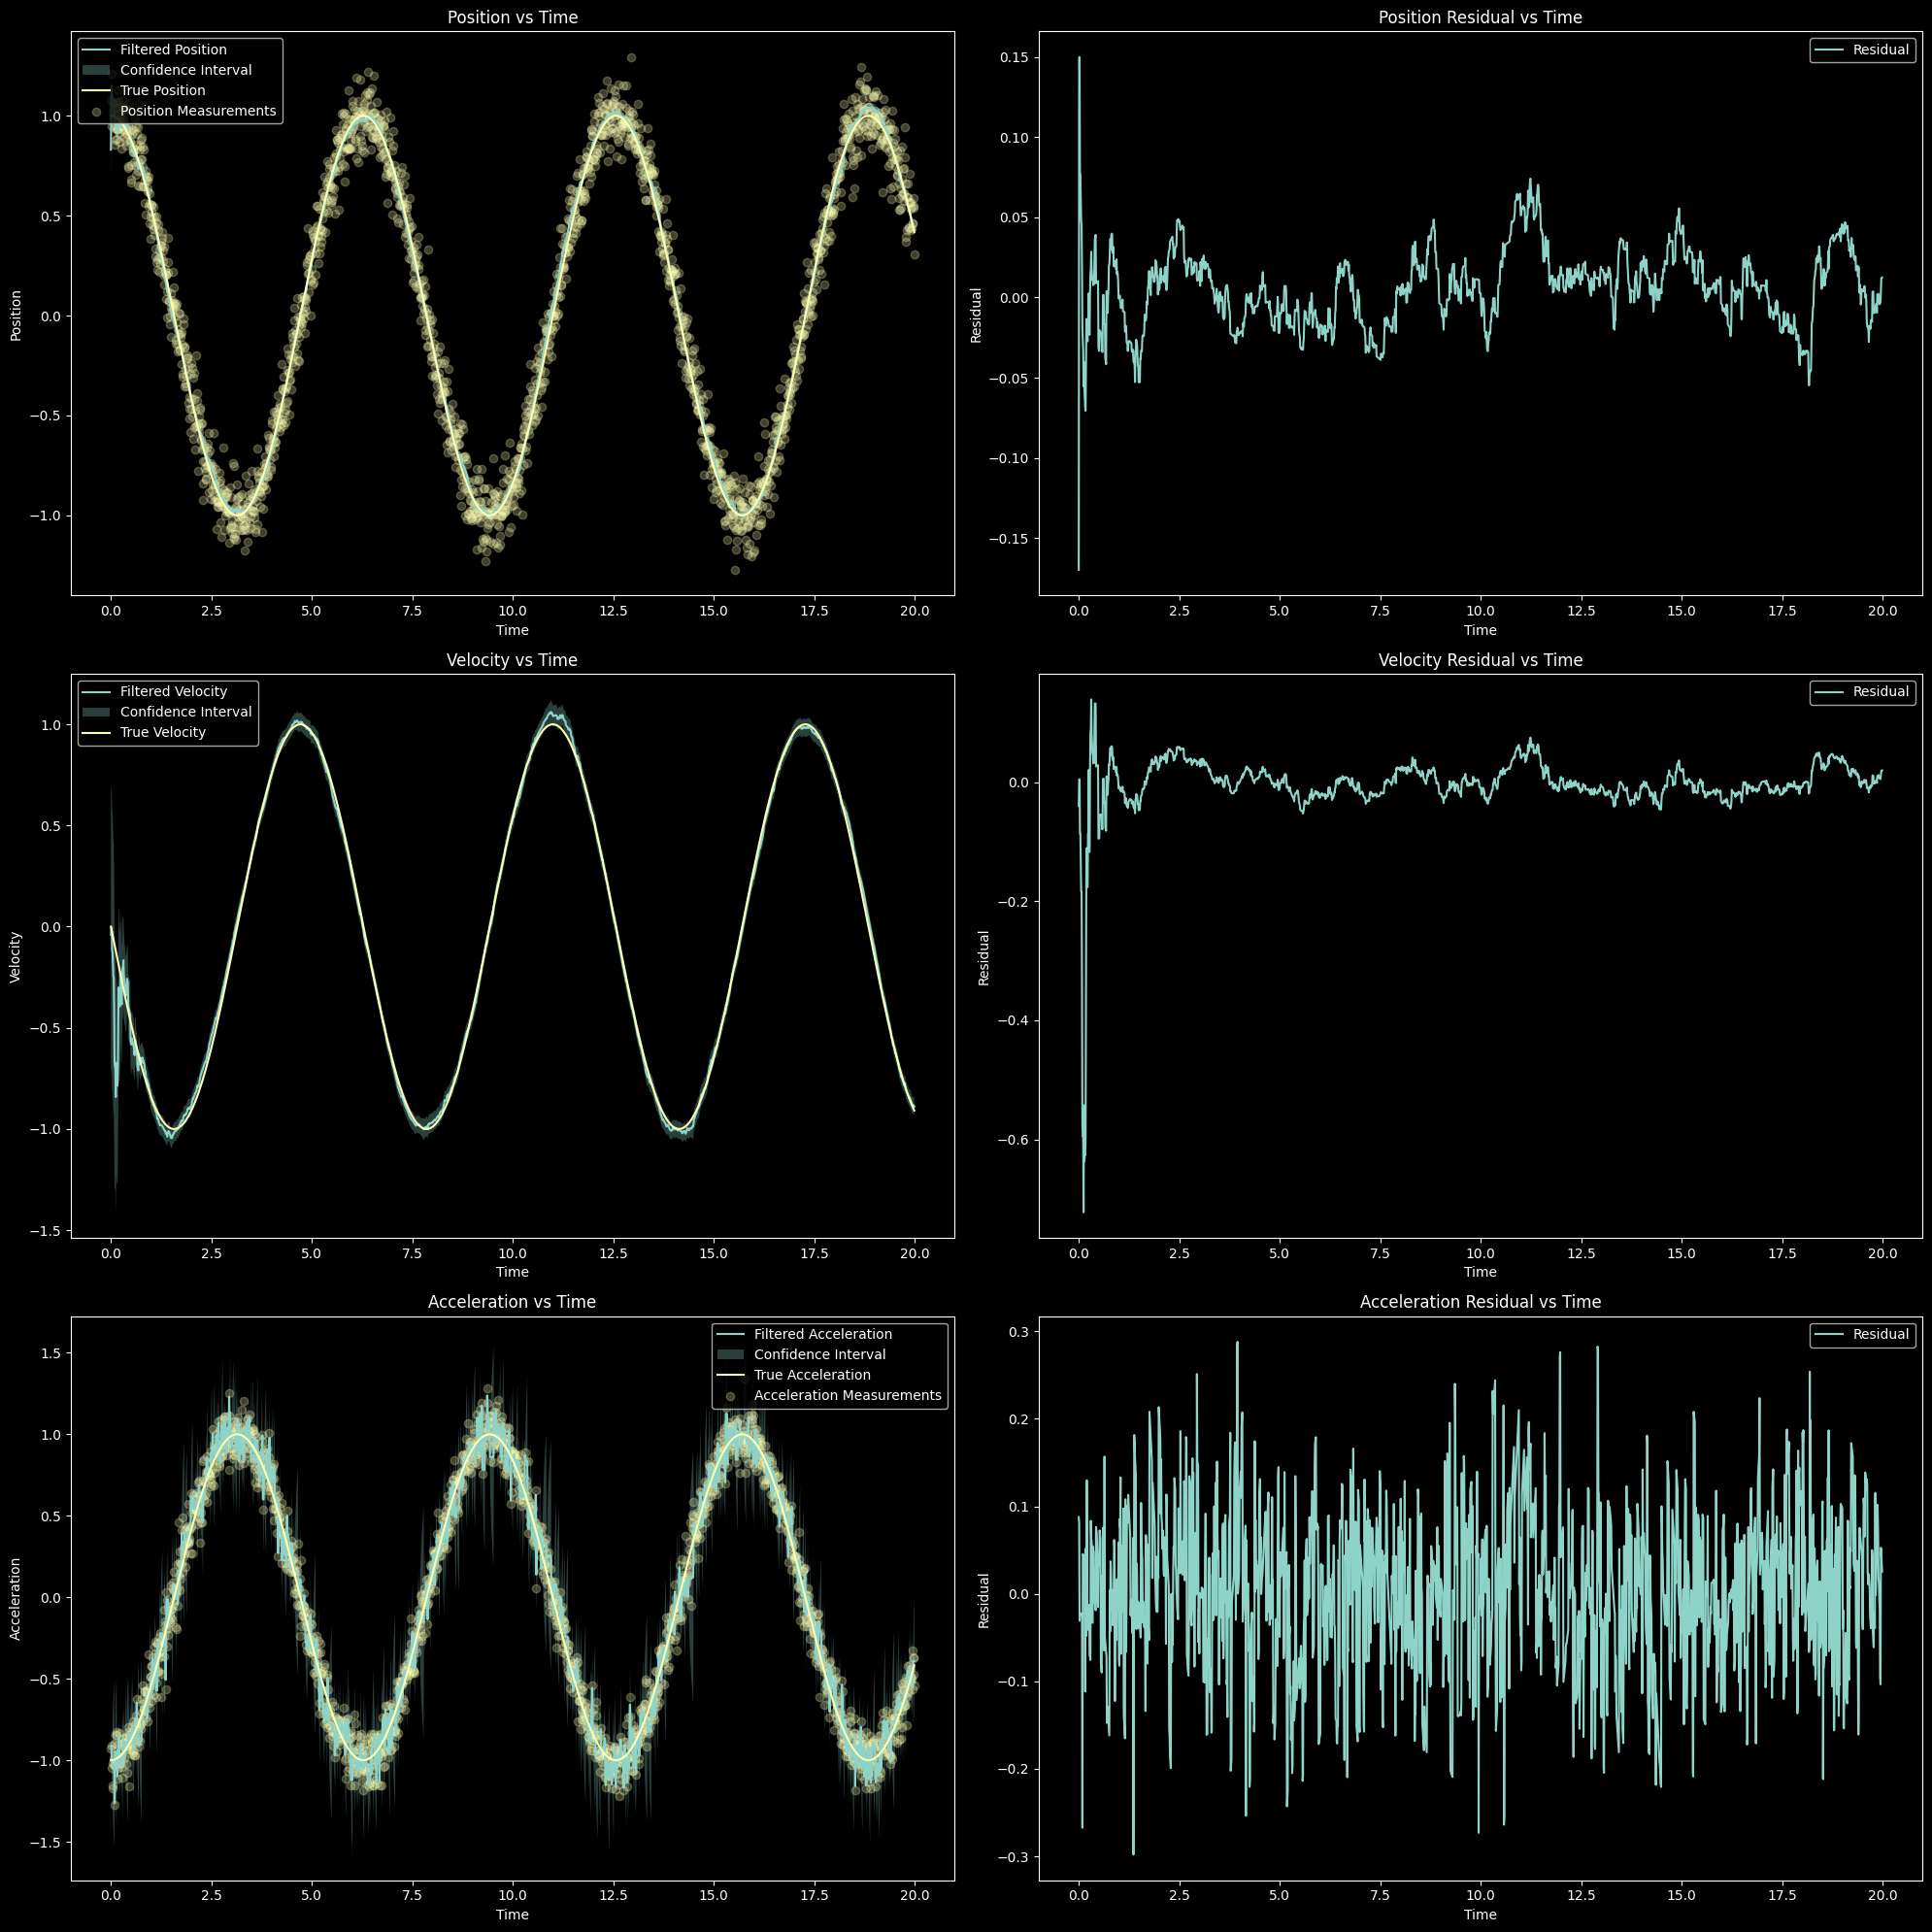

In [9]:
# Plotting position, velocity, acceleration, state variance, and residual over time
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for ind, label in enumerate(["Position", "Velocity", "Acceleration"]):
  # Plotting position vs time
  axs[ind, 0].plot(times, state_history[ind, :], label='Filtered {}'.format(label))
  axs[ind, 0].fill_between(times, state_history[ind, :] - np.sqrt(cov_history[ind, ind, :]),
            state_history[ind, :] + np.sqrt(cov_history[ind, ind, :]),
            alpha=0.3, label='Confidence Interval')
  axs[ind, 0].plot(times, true_states[ind, :], label='True {}'.format(label))
  if ind == 0:
    axs[ind, 0].scatter(times, pos_measurements.T, label='Position Measurements', alpha=0.25)
  if ind == 2:
    axs[ind, 0].scatter(times, accel_measurements.T, label='Acceleration Measurements', alpha=0.25)

  axs[ind, 0].set_xlabel('Time')
  axs[ind, 0].set_ylabel(label)
  axs[ind, 0].set_title('{} vs Time'.format(label))
  axs[ind, 0].legend()

  # Plotting residual vs time
  axs[ind, 1].plot(times, state_history[ind, :] - true_states[ind, :], label='Residual')
  axs[ind, 1].set_xlabel('Time')
  axs[ind, 1].set_ylabel('Residual')
  axs[ind, 1].set_title('{} Residual vs Time'.format(label))
  axs[ind, 1].legend()


# # Plotting state variance vs time
# axs[3 - 3, 1].plot(times, cov_history[1, 1, :], label='Velocity Variance')
# axs[3 - 3, 1].set_xlabel('Time')
# axs[3 - 3, 1].set_ylabel('Variance')
# axs[3 - 3, 1].set_title('Velocity Variance vs Time')
# axs[3 - 3, 1].legend()



plt.tight_layout()
plt.show()


In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation


STRIDE = 10

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(cov_history[:, :, 0], cmap='hot', interpolation='nearest')
fig.colorbar(im, cax=cax, orientation='vertical')  # Add colorbar

def animate(i):
  print("Animating frame {} of {}".format(i, len(times[::STRIDE])), end='\r')
  ax.clear()
  im = ax.imshow(cov_history[:, :, i * STRIDE], cmap='viridis', interpolation='nearest')
  ax.set_title('Covariance Matrix at Time Step {}'.format(i))
  ax.set_xlabel('State Dimension')
  ax.set_ylabel('State Dimension')


ani = animation.FuncAnimation(fig, animate, frames=len(times[::STRIDE]), interval=10, blit=False)
plt.close()
ani
